In [4]:
import gym
import torch
import torch.nn as nn
import random
from collections import namedtuple
import math
import numpy as np
import time
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

In [19]:
# Init Weights and Biases
import wandb

wandb.init(project="my-test-project", entity="hugoallegaert")

In [5]:
env_name = "Taxi-v3"
env = gym.make(env_name)
print('Observation:', env.observation_space.n, env.desc.shape[1], env.desc.shape[0])
print('Action:', env.action_space.n)

Observation: 500 11 7
Action: 6


### Deep QNetwork

nn.module = base for all neural network

In [6]:
class DQN(nn.Module):
    def __init__(self, env):
        super().__init__()
        # init dqn layer
        self.emb = nn.Embedding(500, 10)
        self.fc1 = nn.Linear(in_features=10, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=50)
        self.out_features = nn.Linear(in_features=50, out_features=env.action_space.n)
    
    def forward(self, input_t):
        #print(input_t)
        input_t = nn.functional.relu(self.fc1(self.emb(input_t)))
        #print(input_t)
        #input_t = nn.functional.relu(self.fc1(input_t))
        input_t = nn.functional.relu(self.fc2(input_t))
        input_t = self.out_features(input_t)
        return input_t

### Experience class

In [7]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward', 'done'))

### Replay Memory class

In [8]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

### Epsilon Greedy Strategy class

In [9]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * (current_step) * self.decay) # TODO fix it

0.0005
63.245553203367585
0.00344791986523163
0.00344791986523163
s: 0.00344791986523163
0.0023025850929940454
test: 0.001999930272878454


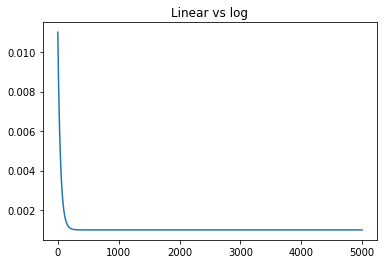

In [462]:
def plot_test(e, r):
        lines = []
        fig = plt.figure(1, figsize=(15, 7))
        plt.clf()
        ax1 = fig.add_subplot(111)

        plt.title('Training...')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Duration & Rewards')
        #ax1.set_ylim(-2 * max_steps_per_episode, max_steps_per_episode + 10)
        ax1.plot(e, color="C1", alpha=0.2)
        ax1.plot(r, color="C2", alpha=0.2)
        #lines.append(ax1.plot(mean_steps, label="steps", color="C1")[0])
        lines.append(ax1.plot(r, label="rate", color="C2")[0])
        
        #ax1.legend(lines, labs, loc=3)
        display.clear_output(wait=True)
        plt.pause(0.001)

def test_decay(eps, eps_min, decay, episode):
    return eps_min + (eps - eps_min) * math.exp(-1. * (episode) * decay)

def log_decay(v_start, v_min, max_step, current_step):
    rate = math.log(v_min/v_start)*-1/max_step
    value = v_min + (v_start*(1-rate)**current_step)
    return value

eps = 1
eps_min = 0.001
#decay = 0.001
decay = 2000

half = eps / 2

#rate = math.log(0.001 / 1) / 2000

rate = 1 - (0.001 / 2000)
rate = 0.0005
print(rate)
#print(eps * math.exp(-1. * (2000) * rate))
#print(eps_min + (eps - (rate * 1000)))

episode = 1000
test = eps - rate * 1000
#print('test:',test)
#print(math.exp(-1. * (episode) * decay))
#print(test_decay(eps, eps_min, decay, 1000))
#print(eps * (1 - 0.00344791)**2000)
print(2000*math.sqrt(0.001))

r = (eps_min**(1/decay))
r = eps - r
print(r)
print(r/eps)
s = r / eps
#s = eps - r / eps
print('s:', s)

x = []
y = []
z = []
s = 0.0034538776394911
s = 0.003800451229771
eps = 0.1
s = math.log(eps_min/eps)*-1/decay
print(s)
for step in range(5000):
    rz = log_decay(0.01, 0.001, 100, step)
    #r = eps - (rate * step)
    #if r < eps_min:
    #    r = eps_min
    x.append(step)
    z.append(rz)
    y.append(r)
print('test:',log_decay(0.01, 0.001, 5000, step))
#plt.plot(x, y)
plt.plot(x, z)
plt.title('Linear vs log')
plt.show()

### Agent class

In [10]:
class Agent():
    def __init__(self, env, strategy): # TODO add device for torch
        self.current_episode = 0
        self.strategy = strategy
        self.num_actions = env.action_space.n
        self.device = torch.device("cpu")
        
    def get_epsilon(self):
        epsilon = self.strategy.get_exploration_rate(self.current_episode)
        return epsilon
    
    def select_action(self, state, policy_network):
        rate = self.strategy.get_exploration_rate(self.current_episode)
        #print(rate)
        # random.uniform(0, 1)?
        if rate > random.random():
            return random.randrange(self.num_actions) # explore
        else:
            with torch.no_grad(): # No grad because we use the model to select an action and not for training
                predicted = policy_network(torch.tensor([state], device=self.device)) # TODO check diff no tensor
                return predicted.argmax(dim=1).item() # exploit        

### Usefull function

In [11]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    tensor_state = torch.cat(batch.state)
    tensor_action = torch.cat(batch.action)
    tensor_reward = torch.cat(batch.reward)
    tensor_next_state = torch.cat(batch.next_state)
    tensor_done = torch.cat(batch.done)
    return (tensor_state, tensor_action, tensor_reward, tensor_next_state, tensor_done)

#https://www.youtube.com/watch?v=ewRw996uevM&list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv&index=18 15.00min
class QValues():
    device = torch.device("cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(1)) # send all states and actions pairs and get list of qvalues
    
    @staticmethod
    def get_next(target_net, next_states):
        values = target_net(next_states).max(dim=1)[0]
        return values
        
def get_game_state(env):
    taxi_row, taxi_col, pass_idx, dest_idx = env.decode(env.s)
    rend = env.desc.copy()
    if pass_idx < 4:
        rend[1 + env.locs[pass_idx][0]][2 * env.locs[pass_idx][1] + 1] = 'P'
    rend[1 + env.locs[dest_idx][0]][2 * env.locs[dest_idx][1] + 1] = 'D'
    rend[1 + taxi_row][2 * taxi_col + 1] = 'T'
    rend = rend.view(np.uint8).astype(np.float32) # Char to float
    rend = torch.tensor(rend) # numpy to tensor
    #print(rend.unsqueeze(1))
    return rend.unsqueeze(0)

def moving_average(x, periods=5):
        if len(x) < periods:
            return x
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        res = (cumsum[periods:] - cumsum[:-periods]) / periods
        return np.hstack([x[:periods-1], res])


def plot_durations(max_steps_per_episode, episode_durations, reward_in_episode, epsilon_vec):
        lines = []
        fig = plt.figure(1, figsize=(15, 7))
        plt.clf()
        ax1 = fig.add_subplot(111)

        plt.title('Training...')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Duration & Rewards')
        ax1.set_ylim(-2 * max_steps_per_episode, max_steps_per_episode + 10)
        ax1.plot(episode_durations, color="C1", alpha=0.2)
        ax1.plot(reward_in_episode, color="C2", alpha=0.2)
        mean_steps = moving_average(episode_durations, periods=5)
        mean_reward = moving_average(reward_in_episode, periods=5)
        lines.append(ax1.plot(mean_steps, label="steps", color="C1")[0])
        lines.append(ax1.plot(mean_reward, label="rewards", color="C2")[0])
        

        ax2 = ax1.twinx()
        ax2.set_ylabel('Epsilon')
        lines.append(ax2.plot(epsilon_vec, label="epsilon", color="C3")[0])
        labs = [l.get_label() for l in lines]
        ax1.legend(lines, labs, loc=3)
        display.clear_output(wait=True)
        plt.pause(0.001)

### Main program

In [21]:
batch_size = 128
gamma = 0.99 # TODO try closer to 0 and graph
eps_start = 1
eps_end = 0.01
eps_delay = 0.001
target_update = 20 # update target network every 20 episode
memory_size = 50000 # TODO try memory size and batch
# TODO add decay function for lr and closer to 1 at first ?
lr = 0.001 # How quickly abandon the previous q value in the table for the new q value for the same pair (s,a) at a later timestep
num_episodes = 3000

run = wandb.init(project="my-test-project", entity="hugoallegaert")
'''wandb.config = {
    "learning_rate": 0.001,
    "batch_size": 128,
    "epsilon": 1
}'''
#wandb.run.name = "test"
#wandb.run.save()

'wandb.config = {\n    "learning_rate": 0.001,\n    "batch_size": 128,\n    "epsilon": 1\n}'

In [24]:
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_delay)
agent = Agent(env, strategy)
memory = ReplayMemory(memory_size)

policy_net = DQN(env)
target_net = DQN(env)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() # eval mode, not training
optimizer = torch.optim.Adam(params=policy_net.parameters(), lr=lr)
device = torch.device("cpu")

In [22]:
max_step = 100
all_rewards = []
epsilon_vec = []
episode_durations = []
for episode in range(num_episodes):
    #clear_output(wait=True)
    print("Training episode: {0}/{1}".format(episode, num_episodes), end="\r")
    state = env.reset()
    episode_reward = 0
    for step in range(max_step):
        # Do action
        action = agent.select_action(state, policy_net)
        new_state, reward, done, info = env.step(action)
        memory.push(Experience(torch.tensor([state], device=device), 
                               torch.tensor([action], device=device),
                               torch.tensor([new_state], device=device),
                               torch.tensor([reward], device=device),
                               torch.tensor([done], device=device, dtype=torch.bool)))
        state = new_state
        episode_reward += reward
        # Train model
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states_b, actions_b, rewards_b, new_states_b, dones_b = extract_tensors(experiences)
            # predict q values
            current_q_values = QValues.get_current(policy_net, states_b, actions_b)
            # expected q values
            next_q_values = QValues.get_next(target_net, new_states_b)
            #print(next_q_values)
            target_q_values = (next_q_values * gamma) + rewards_b # look better ?
            #target_q_values = (~dones_b * next_q_values * gamma) + rewards_b # TODO check how work ~dones_b
            # compute loss
            loss = nn.functional.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            
            # wandl log
            #wandb.log({"loss": loss})
            # Optional
            #wandb.watch(policy_net)
            
            #loss = nn.functional.huber_loss(current_q_values, target_q_values.unsqueeze(1))
            #loss = nn.functional.smooth_l1_loss(current_q_values, target_q_values.unsqueeze(1))
            # Optimize the model
            optimizer.zero_grad() # prevent accumulating gradients during back props
            loss.backward() # compute the gradient of the loss with respect of weight and biases in the policy net
            for param in policy_net.parameters(): # Clips gradients computed during backpropagation to avoid explosion of gradients
                param.grad.data.clamp_(-1, 1)
            optimizer.step() # update the weight and biases with the just previous gradients computed     
        if done:
            break
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict()) # update target net with policy net weight
    wandb.log({"reward": episode_reward, "duration": step, "epsilon": agent.get_epsilon()})
    all_rewards.append(episode_reward)
    episode_durations.append(step)
    epsilon_vec.append(agent.get_epsilon())
    agent.current_episode += 1
    #plot_durations(max_step, episode_durations, all_rewards, epsilon_vec)

In [28]:
run.finish()

NameError: name 'run' is not defined

In [23]:
#print((~dones_b * next_q_values * gamma) + rewards_b)
#print(dones_b)
#print((next_q_values * gamma) + rewards_b)
#print(rewards_b)
t = torch.tensor([[2, 1]])
d = torch.tensor([[False, True]])
r = torch.tensor([[-1, 20]])
print((~d*t*gamma)+r)
print((t*gamma)+r)
print(loss)

tensor([[ 0.9800, 20.0000]])
tensor([[ 0.9800, 20.9900]])
tensor(0.0411, grad_fn=<MseLossBackward0>)


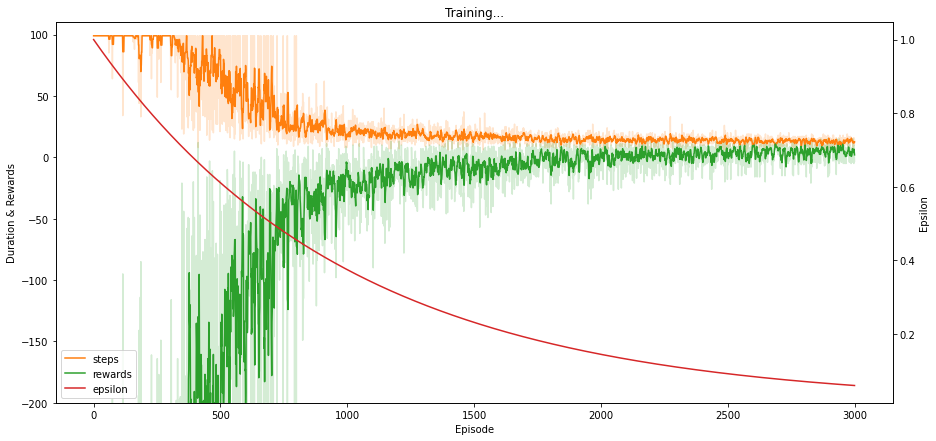

In [16]:
plot_durations(max_step, episode_durations, all_rewards, epsilon_vec)

In [380]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

for param in policy_net.parameters(): # TODO check how its working
    print(param.grad.data)

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
tensor([[ 1.9101e-02, -9.0469e-03, -1.1707e-02, -2.3196e-02,  2.8778e-02,
          4.1770e-02],
        [ 7.8153e-02,  2.4021e-02,  3.0808e-02, -3.8857e-02,  8.8818e-03,
         -1.7605e-02],
        [ 4.6228e-02,  2.5395e-02,  3.6884e-02, -1.0380e-01,  3.5281e-02,
         -3.5281e-02],
        [-4.2663e-02,  1.1226e-02, -5.1577e-02,  4.1954e-02,  9.7190e-04,
          2.2471e-02],
        [ 7.8629e-05, -3.4866e-03,  2.4578e-02, -4.6193e-02,  1.8654e-02,
         -6.3072e-02],
        [ 8.7637e-03,  1.2344e-02,  1.7516e-02, -2.9955e-02,  4.1948e-04,
         -4.1219e-02],
        [-1.5110e-02,  1.5879e-03,  1.6122e-02, -1.0205e-03, -1.1774e-02,
         -1.6279e-02],
        [ 6.7951e-04, -2.4989e-03,  7.1783e-03, -1.4747e-02, -5.2872e-03,
          2.3270e-04],
      

### Test IA

In [17]:
for episode in range(3):
    state = env.reset()
    game = "*** Game {0} ***\n".format(episode + 1)
    time.sleep(1)
    episode_reward = 0
    for step in range(max_step):
        clear_output(wait=True)
        print(game, env.render('human'), end='\n')
        time.sleep(0.3)
        
        action = agent.select_action(state, policy_net)
        state, reward, done, info = env.step(action)
        episode_reward += reward
        if done:
            clear_output(wait=True)
            print(game, env.render('ansi'), end='\n')
            if reward == 1:
                print("*** You Won {0} ***".format(episode_reward))
                time.sleep(3)
            else:
                print("*** Your score {0} ***".format(episode_reward))
                time.sleep(3)
            clear_output(wait=True)
            break

*** Game 3 ***
 +---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

*** Your score 6 ***


### Evaluate

In [27]:
total_steps, total_penalties = 0, 0
episodes = 1000
max_steps = 100
for episode in range(episodes):
    state = env.reset()
    nb_steps, penalties, reward = 0, 0, 0
    for step in range(max_steps):
        action = agent.select_action(state, policy_net)
        state, reward, done, info = env.step(action)
        if reward == -10:
            penalties += 1
        if done == True:
            break
        if step >= max_steps:
            penalties += 1
            break
    total_penalties += penalties
    total_steps += step
        
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_steps / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")  

Results after 1000 episodes:
Average timesteps per episode: 13.982
Average penalties per episode: 0.096


MSE loss score after 3000 episode training :  
Results after 100 episodes:  
Average timesteps per episode: 17.08  
Average penalties per episode: 1.19  

HUBER loss score after 3000 episode training:  
Results after 100 episodes:  
Average timesteps per episode: 17.12  
Average penalties per episode: 0.89  